# Predictor de precios de laptops

Dataset obtenido de: https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset

Datos del dataset scrapeados de: https://www.pccomponentes.com/

Este notebook usa un dataset para predecir el precio de una laptop, segun su CPU, GPU, cantidad de memoria RAM, cantidad de almacenamiento, tipo de almacenamiento, etc.

In [1]:
#############################################################
# BLOQUE DE CONFIGURACION PARA CAMBIOS RAPIDOS EN EL CODIGO #
#############################################################
#
# Marca de la laptop a predecir. Si es "" no se filtrara por marca
MARCA_LAPTOP = ""
#
# Que hacer con los outliers encontrados
# 0: No hacer nada
# 1: Remover outliers
# 2: Imputar outliers
REMOVER_OUTLIERS = -1

# Preprocesamiento

Primero que nada importamos todas las librerias que debemos usar.

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
%matplotlib inline

random.seed(a=None, version=2)

Y algunas funciones generales: 2 para detectar outliers usando IQR y Z-Score, una para remover las filas con outliers, uno para cambiar los valores de ls outliers por NaN, y otro para hacer el label encode.

In [3]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites para identificar valores atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Identificar valores atípicos
    valores_atipicos = df[(df[column] < limite_inferior) | (df[column] > limite_superior)]
    print("El valor del IRQ es: ", IQR)
    print("El valor del límite inferior es :", limite_inferior)
    print("El valor del límite superior es :", limite_superior)
    print("Valores Atípicos Detectados :")
    print(valores_atipicos[column])

    data = (IQR, limite_inferior, limite_superior)

    return valores_atipicos

def detect_outliers_zscore(df, column):
    # Calcular el Z-Score de los datos
    df['z_score'] = (df[column] - df[column].mean()) / df[column].std()
    # Identificar valores atípicos
    # Por ejemplo, los puntos de datos donde el Z-Score es mayor que 2 o menor que -2
    valores_atipicos = df[np.abs(df['z_score']) > 2]
    print("Valores Atípicos Detectados:",valores_atipicos)
    return valores_atipicos

def remove_outliers(df, df_outliers):
    df_outliers_index = df_outliers.index.tolist()
    return df.drop(index=df_outliers_index, errors="ignore")

def nan_outliers(df, df_outliers, columna):
    df_outliers_index = df_outliers.index.tolist()
    for i in df_outliers_index:
        df.at[i, columna] = np.nan
    return df

def label_encode_dummy(x, column):
    column_loc = column
    labelencoder = LabelEncoder()
    x[:,column] = labelencoder.fit_transform(x[:,column])
    #x = np.delete(x, column, 1)
    
    return (x, labelencoder.classes_)


### Dataset
Cargamos el dataset, y cambiamos los valores booleanos por valores numericos 1 y 0, para poder ser procesados por el modelo.
Tambien llena los nans de texto, ya que no pueden ser imputados como valores numericos.

In [4]:
df = pd.read_csv("laptops.csv")

if MARCA_LAPTOP != "":
    df = df[df['Brand'] == MARCA_LAPTOP]

df["Status"] = df["Status"].str.replace("New", "1.0")
df["Status"] = df["Status"].str.replace("Refurbished", "0.0")
df["Status"] = pd.to_numeric(df["Status"], errors="coerce")

df["Touch"] = df["Touch"].str.replace("Yes", "0.0")
df["Touch"] = df["Touch"].str.replace("No", "0.0")
df["Touch"] = pd.to_numeric(df["Touch"], errors="coerce")

#Llena los nans (de texto, los numericos se imputan)
df["Storage type"] = df["Storage type"].fillna("SSD")
df["GPU"] = df["GPU"].fillna("No")

df

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,1.0,Asus,ExpertBook,Intel Core i5,8,512,SSD,No,15.6,0.0,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,1.0,Alurin,Go,Intel Celeron,8,256,SSD,No,15.6,0.0,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,1.0,Asus,ExpertBook,Intel Core i3,8,256,SSD,No,15.6,0.0,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,1.0,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,0.0,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,1.0,HP,15S,Intel Core i5,16,512,SSD,No,15.6,0.0,669.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,0.0,2699.99
2156,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,0.0,2899.99
2157,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,0.0,3399.99
2158,Razer Book 13 Intel Evo Core i7-1165G7/16GB/1T...,0.0,Razer,Book,Intel Evo Core i7,16,1000,SSD,No,13.4,0.0,1899.99


Nos fijamos si hay nulls, y si hay nulls los imputa reemplazandolos por el promedio.

In [5]:
df.isnull().any()

Laptop          False
Status          False
Brand           False
Model           False
CPU             False
RAM             False
Storage         False
Storage type    False
GPU             False
Screen           True
Touch           False
Final Price     False
dtype: bool

In [6]:
#Screen tiene NaNs! Los imputa reemplazandolos por el promedio.

imputer = SimpleImputer(missing_values = np.nan, strategy="mean")
imputer = imputer.fit(df.iloc[:, 9:10])
df.iloc[:, 9:10] = imputer.transform(df.iloc[:, 9:10])

df.isnull().any()

Laptop          False
Status          False
Brand           False
Model           False
CPU             False
RAM             False
Storage         False
Storage type    False
GPU             False
Screen          False
Touch           False
Final Price     False
dtype: bool

#### **Matriz de correlacion**

Varios de los valores a tomar en cuenta son categoricos y no se puede representar en una matriz de correlacion. Los que se pueden representar son la RAM, el almacenamiento, y el tamaño de la pantalla. El estado y el touch son booleanos convertidos a 0/1.

<Axes: >

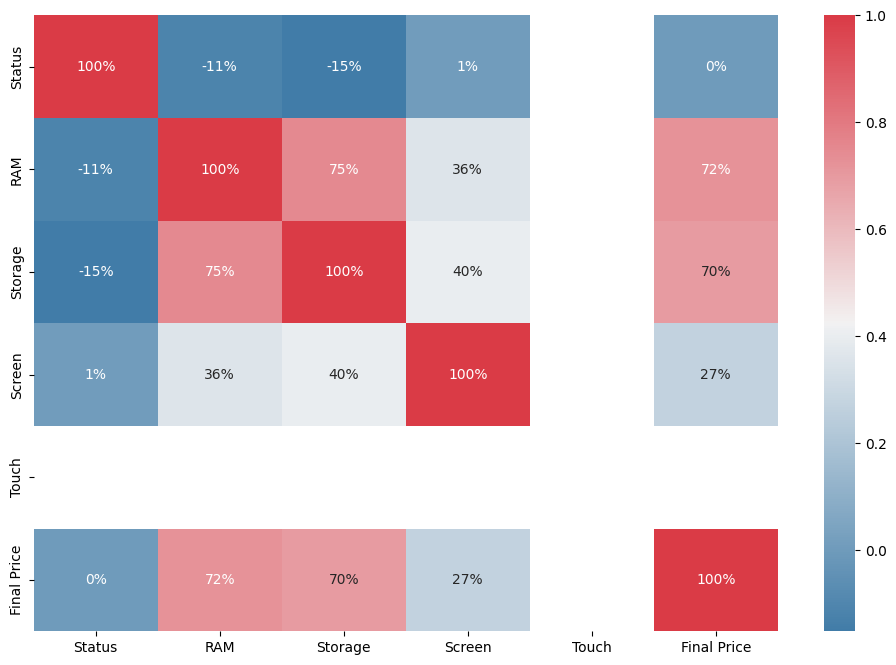

In [7]:
corr = df.corr(numeric_only = True)
plt.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.0%',
cmap=sns.diverging_palette(240, 10, as_cmap=True))

In [8]:
corr['Final Price'].abs().sort_values(ascending=False)

Final Price    1.000000
RAM            0.724946
Storage        0.695631
Screen         0.268169
Status         0.000530
Touch               NaN
Name: Final Price, dtype: float64

En el grafico y la salida de correlaciones podemos ver que los valores numericos que mas afectan al precio son la memoria RAM y la capacidad de almacenamiento, mientras que el estado (nuevo/usado) y el touch de la pantalla no afecta el precio, asi que se descartan.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   float64
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2160 non-null   object 
 8   GPU           2160 non-null   object 
 9   Screen        2160 non-null   float64
 10  Touch         2160 non-null   float64
 11  Final Price   2160 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 202.6+ KB


In [10]:
df.describe()

,Status,RAM,Storage,Screen,Touch,Final Price
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.0,2160.000000
mean,0.693519,15.413889,596.294444,15.168112,0.0,1312.638509
std,0.461139,9.867815,361.220506,1.202214,0.0,911.475417
min,0.000000,4.000000,0.000000,10.100000,0.0,201.050000
25%,0.000000,8.000000,256.000000,14.000000,0.0,661.082500
50%,1.000000,16.000000,512.000000,15.600000,0.0,1031.945000
75%,1.000000,16.000000,1000.000000,15.600000,0.0,1708.970000
max,1.000000,128.000000,4000.000000,18.000000,0.0,7150.470000


## Outliers?

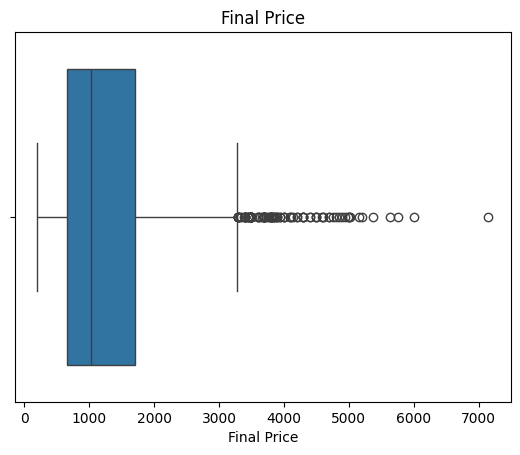

In [11]:
g = sns.boxplot(data = df, x = 'Final Price')

# Add a title and change xlabel
g.set_title('Final Price')
g.set_xlabel('Final Price')
plt.show()

In [12]:
remove_or_nan = REMOVER_OUTLIERS # -1: dont remove outliers; 0: remove; 1: nan
outliers = detect_outliers_iqr(df, "Final Price")
purge_outliers = True #Sacar todos los outliers o solo la primera pasada?

print(f"Detected {len(outliers)} outliers.")

if remove_or_nan != 0:
    if remove_or_nan == 1:
        while len(outliers != 0):
            print(f"Removed {len(outliers)} outliers.")
            df = remove_outliers(df, outliers)
            outliers = detect_outliers_iqr(df, "Final Price")

            if not purge_outliers:
                break
            
    if remove_or_nan == 2:
        df = nan_outliers(df, outliers, "Final Price")
        
        while len(outliers) != 0:
            df = nan_outliers(df, outliers, "Final Price")
            print(f"NaNed {len(outliers)} outliers.")
            imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
            imputer = imputer.fit(df.iloc[:,11:12])
            df.iloc[:, 11:12] = imputer.transform(df.iloc[:, 11:12])
            outliers = detect_outliers_iqr(df, "Final Price")

            if not purge_outliers:
                break
    
df

El valor del IRQ es:  1047.8875
El valor del límite inferior es : -910.7487500000002
El valor del límite superior es : 3280.8012500000004
Valores Atípicos Detectados :
100     3299.99
292     3699.01
307     3699.01
351     3599.00
361     3399.00
         ...   
2128    4999.00
2150    3299.99
2151    3399.99
2154    4699.99
2157    3399.99
Name: Final Price, Length: 103, dtype: float64
Detected 103 outliers.


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,1.0,Asus,ExpertBook,Intel Core i5,8,512,SSD,No,15.6,0.0,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,1.0,Alurin,Go,Intel Celeron,8,256,SSD,No,15.6,0.0,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,1.0,Asus,ExpertBook,Intel Core i3,8,256,SSD,No,15.6,0.0,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,1.0,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,0.0,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,1.0,HP,15S,Intel Core i5,16,512,SSD,No,15.6,0.0,669.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,0.0,2699.99
2156,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,0.0,2899.99
2157,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,0.0,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,0.0,3399.99
2158,Razer Book 13 Intel Evo Core i7-1165G7/16GB/1T...,0.0,Razer,Book,Intel Evo Core i7,16,1000,SSD,No,13.4,0.0,1899.99


In [13]:
df.isnull().any()

Laptop          False
Status          False
Brand           False
Model           False
CPU             False
RAM             False
Storage         False
Storage type    False
GPU             False
Screen          False
Touch           False
Final Price     False
dtype: bool

# Prediccion

En esta seccion se eligen las columnas a usar como X, y luego se crean variables dummy para las variables caregoricas.


In [14]:
Xcolumns = [
    #'Status', 
    #'Brand',
    'Model',
    'CPU', 
    'RAM', 
    'Storage', 
    #'Storage type',
    'GPU',
    'Screen'
    ]

X = df[Xcolumns].values
y = df['Final Price'].values

X, lista_gpu = label_encode_dummy(X, Xcolumns.index('GPU')) #GPU
#X, lista_storagetype = label_encode_dummy(X, Xcolumns.index('Storage type')) #Storage Type
X, lista_cpu = label_encode_dummy(X, Xcolumns.index('CPU')) #CPU
X, lista_models = label_encode_dummy(X, Xcolumns.index('Model')) #Model
#X, lista_brands = label_encode_dummy(X, Xcolumns.index('Brand')) #Brand

labeled_X = X

onehotencoder = make_column_transformer(
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('GPU')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Storage type')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('CPU')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Model')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Brand')]), 
    remainder = "passthrough")
X = onehotencoder.fit_transform(X)
X

<2160x194 sparse matrix of type '<class 'numpy.float64'>'
	with 12954 stored elements in Compressed Sparse Row format>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler_x = StandardScaler(with_mean=False)

X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_pred = regression.predict(X_test)
y_pred

array([ 904.73192441,  941.23599654,  773.10555531, 1370.99417957,
        733.99826215, 1436.51360021,  497.28262205,  606.30183056,
        265.88162162,  341.81125841,  527.18638981, 1243.95133236,
       3631.41681845,  641.31501166,  642.39265748,  906.87397582,
        587.56920155, 2733.90188482, 1049.43767809, 4168.45547351,
        606.30183056, 1152.12817393, 1478.51168687,  857.3204976 ,
        826.43658842, 1038.00769901, 1265.66632809,  885.97341458,
       1150.4067183 ,  922.63509114, 1404.93259423,  856.13837883,
        779.68855117, 1066.71084194, 1189.77500102,  679.25619451,
       3768.85098061,  618.48525741,  208.37863088, 2881.7236153 ,
        640.02442007,  733.99826215, 2528.85419718,  461.54101059,
        678.47633766, 1213.70107099, 1543.31054512,  565.64259812,
       2669.88595439, 3806.19645801,  391.65733263,  260.28243099,
       3092.77720146,  499.0818048 ,  330.70881395, 1278.22394298,
       1777.00737388,  660.11660389, 1356.26996841,  403.17854

In [16]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head(60)

,Actual,Predicted
0,586.54,904.731924
1,999.00,941.235997
2,809.45,773.105555
3,999.00,1370.994180
4,1031.89,733.998262
5,905.84,1436.513600
6,383.26,497.282622
7,379.01,606.301831
8,734.64,265.881622
9,399.00,341.811258


In [17]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 230.65703298433604
Mean Squared Error: 121102.57921676832
Root Mean Squared Error: 347.9979586387948
R^2 0.8511536776436199


## Visualizacion de datos

Mientras esten mas juntos formando una linea, mejor estan. Eso quiere decir que las predicciones son mas precisas.

Si la marca elegida tiene muchas entradas, por ejemplo apple, las predicciones saldran mas precisas.

Si la marca tiene muy pocas entradas es muy probable que el R^2 de muy malos resultados, pero que el grafico de comparacion de precios no este tan mal.

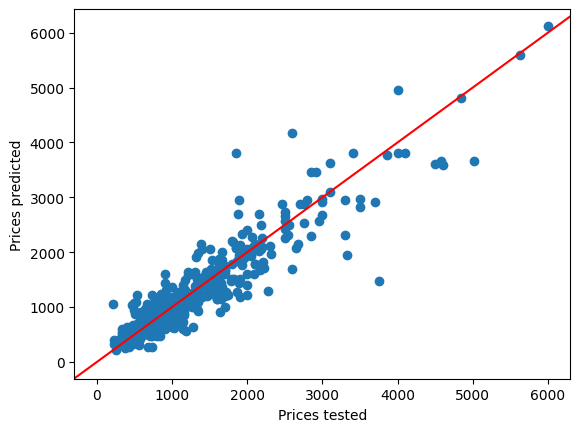

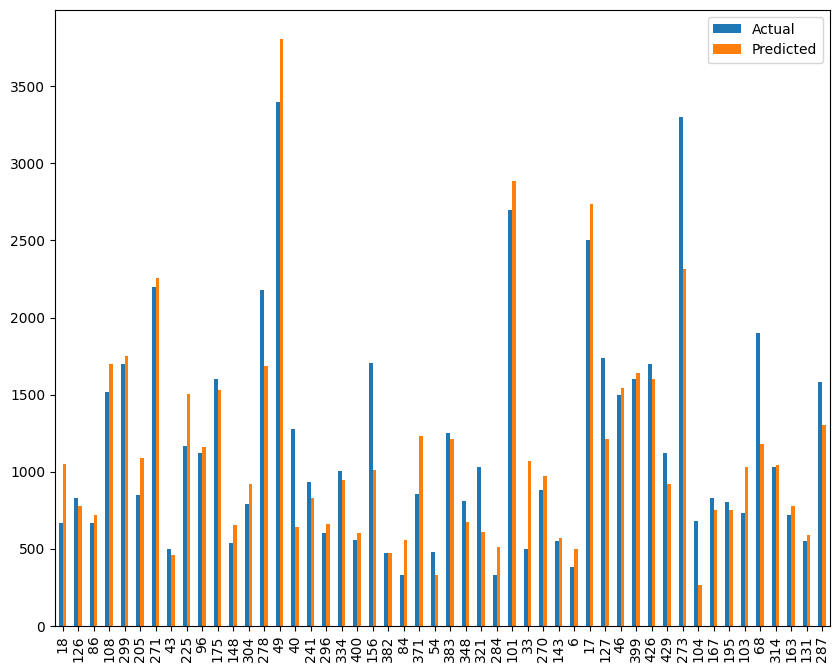

In [18]:
plt.scatter(y_test, y_pred)
plt.axline((0,0),(5000,5000), color="red")
plt.xlabel("Prices tested")
plt.ylabel("Prices predicted")
df1.sample(frac=1).head(50).plot(kind='bar',figsize=(10,8))
plt.show()

# Predictor de precios de Laptops

Es necesario instalar el modulo de `ipywidgets` para esta parte.

Podes probar el predictor con los controles que aparecen abajo. Se puede seleccionar el modelo, cpu, ram, almacenamiento, gpu y tamaño de pantalla. La marca se selecciona arriba en el bloque de configuracion del notebook, ya que el entrenamiento esta separado por marca (o no) para ser mas preciso.

In [19]:
@interact
def predict_laptop_price(#status = (0.0, 1.0, 1.0), 
                      #brand=list(lista_brands),
                      model=list(lista_models),
                      cpu=list(lista_cpu),
                      ram=(df["RAM"].min(), df["RAM"].max()),
                      storage=(df["Storage"].min(), df["Storage"].max()),
                      #storage_type=list(lista_storagetype),
                      gpu=list(lista_gpu),
                      screen=(4,30,0.1),
                      ):
    #brand = list(lista_brands).index(brand)
    model = list(lista_models).index(model)
    cpu = list(lista_cpu).index(cpu)
    #storage_type=list(lista_storagetype).index(storage_type)
    gpu=list(lista_gpu).index(gpu)
    
    uX = np.array([
           #float(status), 
           #float(brand), 
           float(model), 
           float(cpu), 
           float(ram), 
           float(storage), 
           #float(storage_type), 
           float(gpu),
           float(screen)
                  ])

    pX = labeled_X
    
    pX = np.vstack((pX, uX))

    onehotencoder = make_column_transformer(
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('GPU')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Storage type')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('CPU')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Model')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Brand')]), 
    remainder = "passthrough")
    
    pX = onehotencoder.fit_transform(pX)

    pX = scaler_x.transform(pX)
    
    pred = regression.predict(pX)
    print(pred[-1])

interactive(children=(Dropdown(description='model', options=('100e', '100w', '14S', '14w', '15S', '15U70N', '1…